<a href="https://colab.research.google.com/github/denis201520182022/colorization-project/blob/main/Image_Colorization_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch torchvision matplotlib opencv-python


In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms.functional import rgb_to_grayscale

In [2]:
class ColorizationDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img_color, _ = self.dataset[idx]
    img_gray = rgb_to_grayscale(img_color)

    
    
    return img_gray, img_color



In [ ]:

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
train_dataset = ColorizationDataset(train_dataset)
test_dataset = ColorizationDataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Форма grayscale изображений: torch.Size([32, 1, 64, 64])
Форма цветных изображений: torch.Size([32, 3, 64, 64])
torch.Size([3, 64, 64])


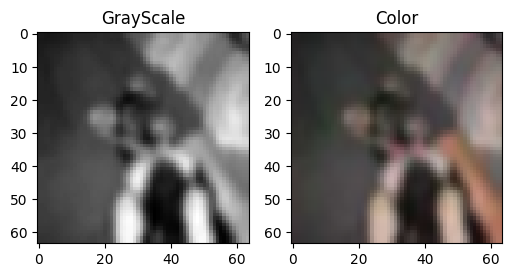

In [7]:

gray_batch, color_batch = next(iter(train_loader))
print("Форма grayscale изображений:", gray_batch.shape)
print("Форма цветных изображений:", color_batch.shape)


plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(gray_batch[0].squeeze(0), cmap='gray')
plt.title('GrayScale')
print(color_batch[0].shape)
plt.subplot(1,2,2)
plt.imshow(color_batch[0].permute(1,2,0))
plt.title('Color')
plt.show()

In [8]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Энкодер: сжимаем информацию
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),                

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),              
        )

        # Декодер: восстанавливаем цвета
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, padding=1, stride=2, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), 
            nn.Sigmoid() 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
model = ColorizationNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)


#model.load_state_dict("colorization_weights_lab_V2.pth")
#optimizer.load_state_dict('optimizer_weights_lab_V2.pth')

In [12]:


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for gray_img, color_img in progress_bar:
        gray_img, color_img = gray_img.to(device), color_img.to(device)
        optimizer.zero_grad()
        output = model(gray_img)
        loss = criterion(output, color_img)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10:   1%|          | 15/1563 [00:03<06:26,  4.01it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'saved_models/colorization_model_rgb.pth')
torch.save(optimizer.state_dict(), 'saved_models/optimizer_weights_rgb.pth')

#files.download("colorization_model_rgb.pth")
#files.download("optimizer_weights_rgb.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:



model.eval() 
test_loss = 0.0

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="")
    for gray_img, color_img in progress_bar:
        
        gray_img = gray_img.to(device).float()
        color_img = color_img.to(device).float()

        outputs = model(gray_img)  

        loss = criterion(outputs, color_img)  

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {average_test_loss:.4f}')

100%|██████████| 313/313 [00:32<00:00,  9.67it/s]

Test Loss: 0.0098
